In [104]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict, train_test_split,GridSearchCV
from sklearn.ensemble import *
from multiprocessing import Pool
import time

### -- Load Data --

In [105]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [106]:
df_mess_train.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [107]:
print("Il y a ",len(df_mess_train["objid"].unique()),"messages différents")

Il y a  6068 messages différents


In [5]:
print("Il y a ",len(df_mess_train["did"].unique()),"objets différents")

Il y a  113 objets différents


In [6]:
#visusalisation de l'output du train
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [7]:
# determine all Base stations that received at least 1 message
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) 

In [8]:
print("Il y a", len(listOfBs),"stations réparties sur le train et le test")

Il y a 259 stations réparties sur le train et le test


### -- Preprocessing --

In [9]:
#fonction donnée (non utilisée)
def feat_mat_const(df_mess_train, listOfBs):
    """Return sparse matrix with one and zeros for each message
    1 column <=> 1 station"""
    df_mess_bs_group = df_mess_train.groupby(['objid'], as_index=False) # group data by message (objid)
    nb_mess = len(np.unique(df_mess_train['objid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    for key, elmt in df_mess_bs_group:
        liste_index = df_mess_bs_group.get_group(key)['rssi'].sort_values(ascending = False).index[:3]
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = 1
        idx = idx + 1
    return df_feat

In [42]:
def get_dict_device_msg(df_mess_train):
    """Return for each object id(key) the list of messages associated (values)"""
    dic_device_msg = {}
    for i in range(0,df_mess_train.shape[0]):
        try :
            liste = dic_device_msg[df_mess_train.loc[i,"did"]]
            liste.append(df_mess_train.loc[i,"objid"])
            dic_device_msg[df_mess_train.loc[i,"did"]] = list(set(liste))#elimine les doublons
        except KeyError :
            dic_device_msg[df_mess_train.loc[i,"did"]] = [df_mess_train.loc[i,"objid"]]
            continue
    return dic_device_msg

In [43]:
dic_device_msg = get_dict_device_msg(df_mess_train)

In [44]:
#verification
'573bf3533e952e19126b256a' in dic_device_msg[473335.0]

True

In [45]:
def get_dict_msg_idx(df_mess_train):
    """Return for each message (key) its idx in the matrix (values)"""
    dic_msg_idx = dict(zip(np.unique(df_mess_train["objid"].values).tolist()\
                            ,range(0,np.unique(df_mess_train["objid"].values).shape[0])))
    return dic_msg_idx

In [46]:
dic_msg_idx = get_dict_msg_idx(df_mess_train)

In [15]:
def feat_mat_const_full(df_mess_train, listOfBs):
    """Return sparse matrix with one and zeros for each message
    group 3 columns <=> 1 station ( latitude, longitude, rssi per station, null if not received)"""
   
    nb_mess = len(np.unique(df_mess_train['objid']))
    matrix = np.zeros((nb_mess,len(listOfBs)*3)) # feature matrix
    dict_station_id = dict(zip(listOfBs.tolist(),range(0,len(listOfBs))))

    #filling matrix nb_msg * nb_stations*3 (long,lat,rssi)
    idx_msg = 0
    for msg in np.unique(df_mess_train['objid']) :
        buffer = df_mess_train[df_mess_train["objid"]==msg] #subset du dataframe pour un msg donnée
        for num_row in range(0,buffer.shape[0]):
            num_base = buffer.iloc[num_row,1]
            idx_base = dict_station_id[num_base] * 3 #lat, long, rsi
            matrix[idx_msg,idx_base] = buffer.iloc[num_row,6] #latitude
            matrix[idx_msg,idx_base+1] = buffer.iloc[num_row,7] #longitude
            matrix[idx_msg,idx_base+2] = buffer.iloc[num_row,4] #rssi
        idx_msg+=1
            
    
    return matrix #sparse matrix 1 row <=> 1 msg

In [16]:
def select_n_station(matrix,nombre):
    """Return a matrix with only nombre of closest stations per message"""
    res = np.zeros((matrix.shape[0],nombre*3))
    rssi_val = matrix[:,np.arange(2,777,3)]
    rssi_val[rssi_val==0] = -1000 #not to take in account the 0 in the argsort
    argsort_matrix = np.argsort(rssi_val,axis=1)
    for j in range(0,nombre):
        for i in range(0,matrix.shape[0]):
            if (matrix[i,(argsort_matrix[i,-1-j]*3)+2]==0):
                res[i,(j*3)+2] = matrix[i,(argsort_matrix[i,-1-j]*3)+2]
                res[i,(j*3)+1] = matrix[i,(argsort_matrix[i,-1-j]*3)+2]
                res[i,(j*3)] = matrix[i,(argsort_matrix[i,-1-j]*3)+2]
            else:
                res[i,(j*3)+2] = matrix[i,(argsort_matrix[i,-1-j]*3)+2] #get nombre higher rssi
                res[i,(j*3)+1] = matrix[i,(argsort_matrix[i,-1-j]*3)+1] #get related longitude
                res[i,(j*3)] = matrix[i,(argsort_matrix[i,-1-j]*3)] #get related latitude
    return res,argsort_matrix

In [136]:
def preprocessing_gen(input_dataset,station_liste,n) : 
    """Return a sparse matrix with 1 and 0
    1 row <=> 1 message
    1 column <=> 1 station
    value 1 <=> n closest stations for a given message
    n*3 last columns corresponding to latitude, longitude, rss of the n closest stations"""
    matrix_1 = feat_mat_const_full(input_dataset,station_liste) #get sparse matrix message X station parameters
    best_station_param, argsort_matrix = select_n_station(matrix_1,n) #select 1st station only
    matrix_2 = np.zeros((matrix_1.shape[0],len(station_liste)+3)) #shape number_message X number station + 3
    for i in range(0,matrix_2.shape[0]):
        matrix_2[i,argsort_matrix[i,-1]] = 1 #set to 1 the value of the closest station
        if(best_station_param[i,-1]!=0):
            matrix_2[i,argsort_matrix[i,-n]] = 1
    matrix_2[:,-n*3:] = best_station_param #fill the last 3 rows with the closest station parameters (lat,long,rssi)
    return matrix_2

In [140]:
preprocessed_train = preprocessing_gen(df_mess_train,listOfBs,1)

Le fait de considérer uniquement la base ayant le rssi le plus élevé pour chaque message est justifié dans le page décrivant notre démarche.

In [146]:
#vérification
preprocessed_train[2]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     

In [21]:
def ground_truth_const(df_mess_train, pos_train):
    """Return the output (pos object) per message"""
    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train
    
    ground_truth_lat = np.array(df_mess_pos.groupby(['objid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['objid']).mean()['lng'])
    return ground_truth_lat, ground_truth_lng

In [22]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)

### -- Prediction & error analysis --

In [22]:
# Validation

In [67]:
def regressor_and_predict(X_train_lat, X_train_long, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    reg.fit(X_train_lat, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train_long, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 
    
    return y_pred_lat, y_pred_lng


#### Prediction with linear regression 

In [24]:
y_pred_lng = cross_val_predict(linear_model.LinearRegression(), preprocessed_train, ground_truth_lng, cv=10)
y_pred_lat = cross_val_predict(linear_model.LinearRegression(), preprocessed_train, ground_truth_lat, cv=10)

In [25]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [26]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [27]:
# Plot error distribution

In [28]:
def err_80(lat,long,lat_pred,long_pred) :
    err_vec = Eval_geoloc(lat , long, lat_pred, long_pred)
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure();
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
    plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
    return np.percentile(err_vec, 80)

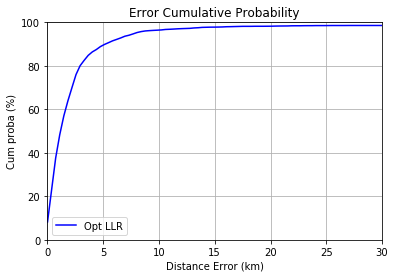

In [29]:
err = err_80(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

In [30]:
print(err)

3296.38599389


Cela représente l'erreur de prédiction : pour 80% de nos objets la vrai position est à +-3296km de la position prédite.

#### Train error

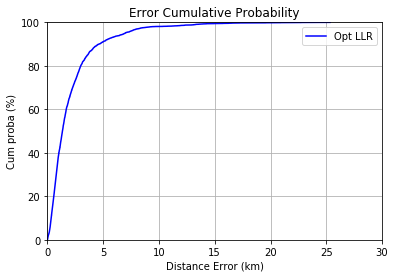

In [33]:
obj_pos = np.array([ground_truth_lat,ground_truth_lng])
obj_pos = np.transpose(obj_pos)

X_train, X_test, y_train, y_test = train_test_split(preprocessed_train,obj_pos,test_size=0.3)
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
obj_pred = reg.predict(X_train)
err_train = err_80(y_train[:,0],y_train[:,1],obj_pred[:,0],obj_pred[:,1])

In [34]:
print(err_train)

2994.48995946


#### Test error

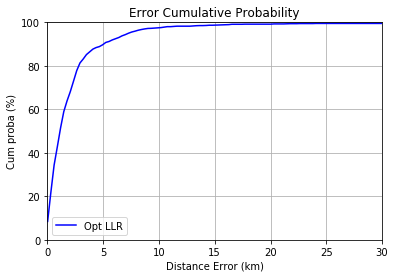

In [35]:
obj_pos_pred = reg.predict(X_test)
err_test = err_80(y_test[:,0],y_test[:,1],obj_pos_pred[:,0],obj_pos_pred[:,1])

In [36]:
print(err_test)

3073.55154083


### -- Leave one device out --

In [37]:
#list of device unique
liste_device = np.unique(df_mess_train["did"].unique())

In [47]:
def get_split(preprocessed_train,ground_truth_lat,ground_truth_lng,liste_device,dic_device_msg,dic_msg_idx):
    """Return a list of split considering each device"""
    all_idx = set(np.arange(0,preprocessed_train.shape[0]).tolist())
    liste_X_test_preprocessed,liste_X_train_preprocessed,\
    liste_y_long_train_preprocessed, liste_y_lat_train_preprocessed, \
    liste_y_long_test_preprocessed, liste_y_lat_test_preprocessed = [],[],[],[],[],[]
    
    
    for device in liste_device :
        liste_msg = dic_device_msg[device]
        idx_test = set()
        for msg in liste_msg:
            idx_test.add(dic_msg_idx[msg])
        idx_train = all_idx - idx_test #différence ensembliste
        liste_X_test_preprocessed.append(preprocessed_train[sorted(list(idx_test))]) #conserve ordre devices
        liste_X_train_preprocessed.append(preprocessed_train[list(idx_train)])
        liste_y_long_train_preprocessed.append(ground_truth_lng[list(idx_train)])
        liste_y_lat_train_preprocessed.append(ground_truth_lat[list(idx_train)])
        liste_y_long_test_preprocessed.append(ground_truth_lng[sorted(list(idx_test))])
        liste_y_lat_test_preprocessed.append(ground_truth_lat[sorted(list(idx_test))])
        
    return liste_X_test_preprocessed,liste_X_train_preprocessed,liste_y_long_train_preprocessed, \
                liste_y_lat_train_preprocessed,liste_y_long_test_preprocessed, liste_y_lat_test_preprocessed

In [48]:
liste_X_test_preprocessed,liste_X_train_preprocessed,liste_y_long_train_preprocessed, \
        liste_y_lat_train_preprocessed,liste_y_long_test_preprocessed, liste_y_lat_test_preprocessed \
        = get_split(preprocessed_train,ground_truth_lat,ground_truth_lng,liste_device,dic_device_msg,dic_msg_idx)

In [155]:
#Verification
dev = liste_device[0]
print(np.allclose(liste_X_test_preprocessed[0],preprocessing_gen(df_mess_train[df_mess_train['did']==dev],listOfBs,1)))

True


In [51]:
#get error 80
def get_error_per_obj (estimator,liste_X_test_preprocessed,liste_X_train_preprocessed,liste_y_long_train_preprocessed, \
        liste_y_lat_train_preprocessed,liste_y_long_test_preprocessed, liste_y_lat_test_preprocessed):
    """Return err 80% for each objet (according to the liste_device order)"""
    
    scores = np.zeros(len(liste_X_test_preprocessed))
    
    for i in range(0,len(liste_X_test_preprocessed)):
        #get latitude predicition
        estimator.fit(liste_X_train_preprocessed[i],liste_y_lat_train_preprocessed[i])
        lat_pred = estimator.predict(liste_X_test_preprocessed[i])
        
        #get longitude prediction
        estimator.fit(liste_X_train_preprocessed[i],liste_y_long_train_preprocessed[i])
        long_pred = estimator.predict(liste_X_test_preprocessed[i])
        
        scores[i] = err_80(liste_y_lat_test_preprocessed[i],liste_y_long_test_preprocessed[i]\
                                   ,lat_pred,long_pred)
        
    return scores

/Users/mehdiregina/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


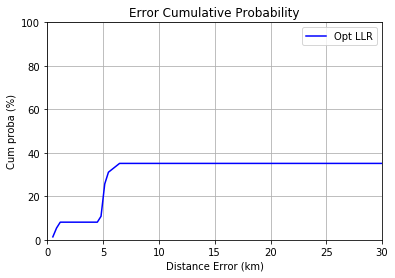

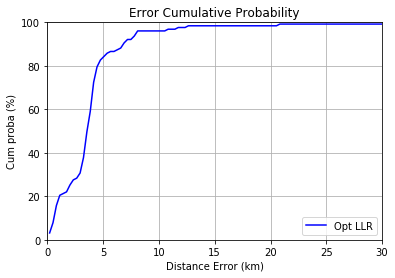

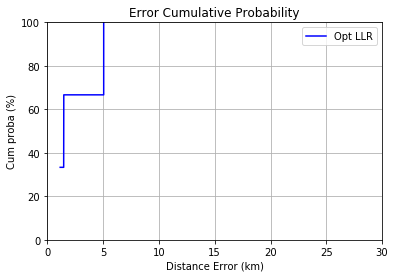

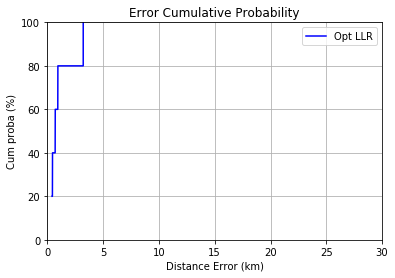

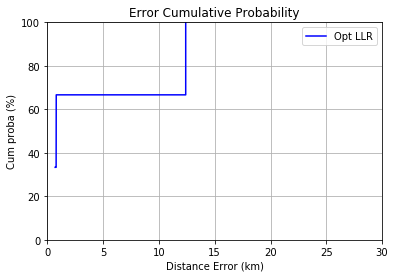

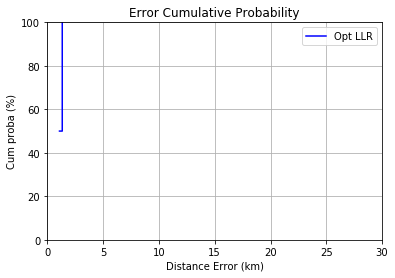

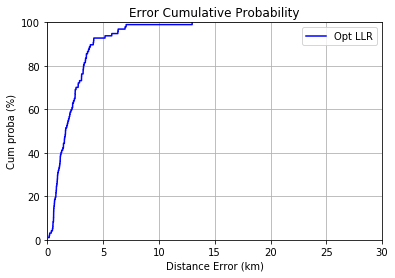

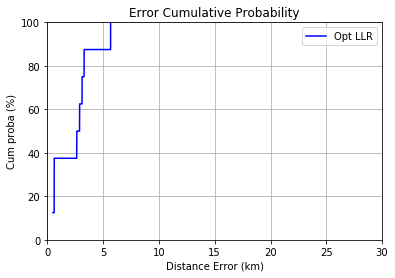

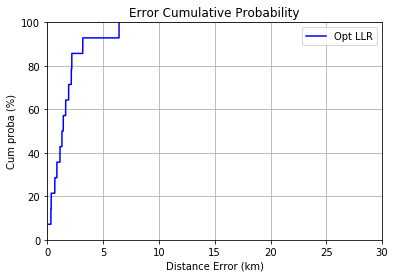

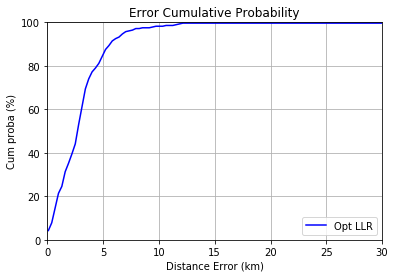

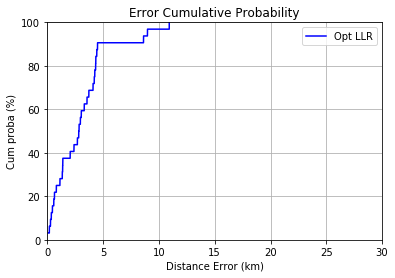

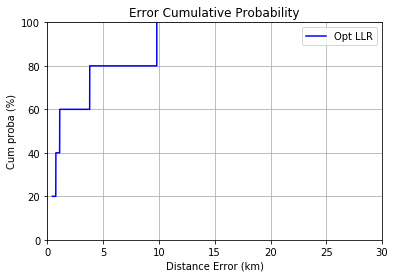

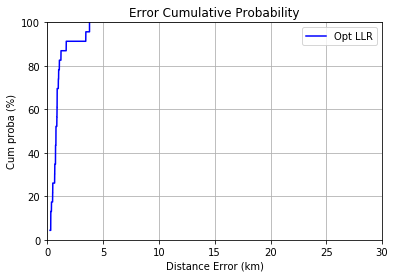

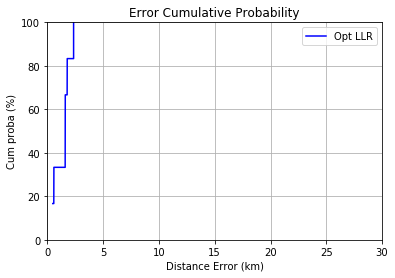

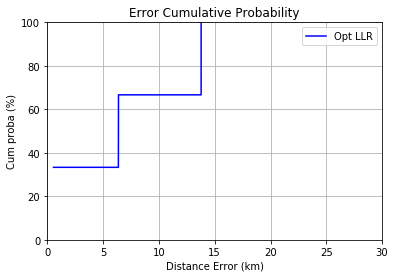

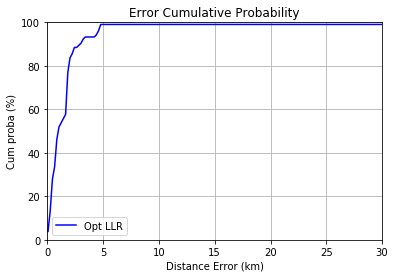

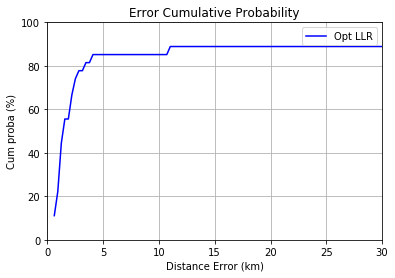

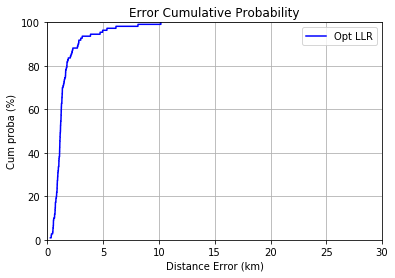

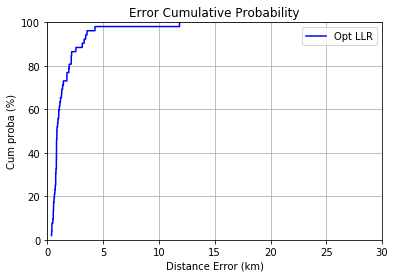

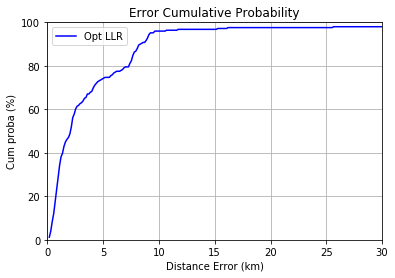

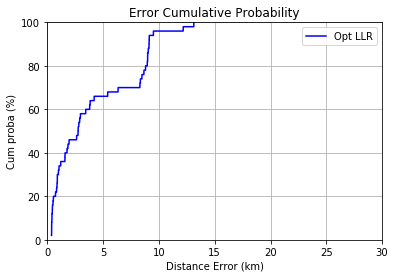

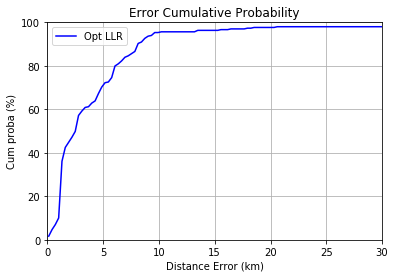

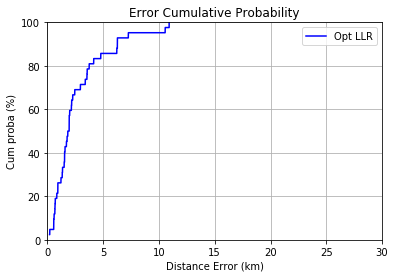

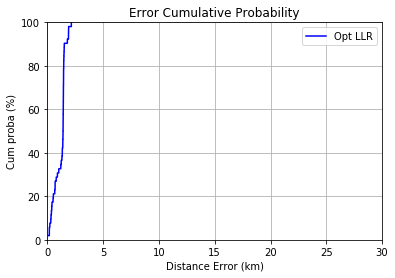

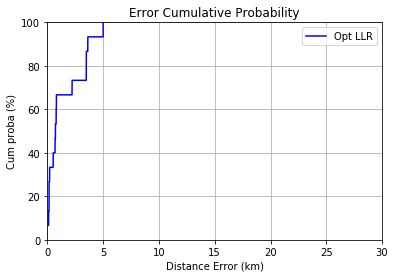

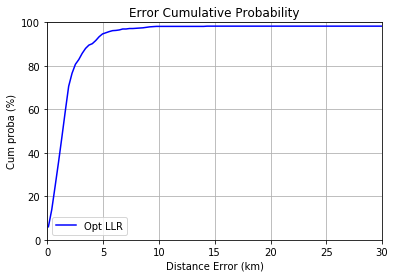

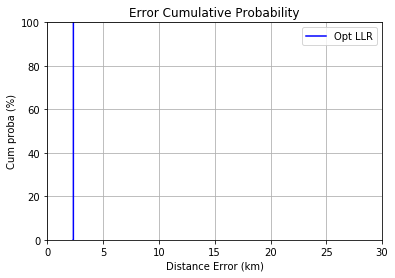

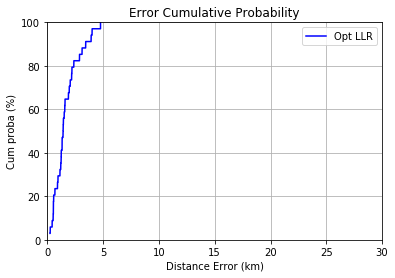

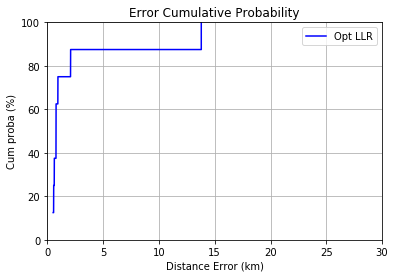

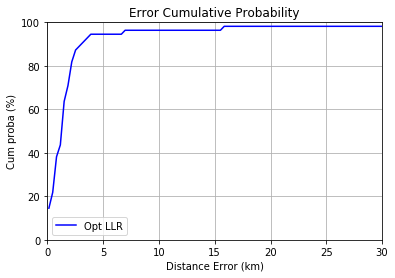

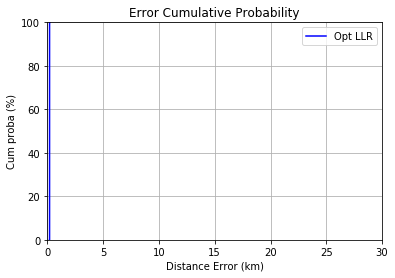

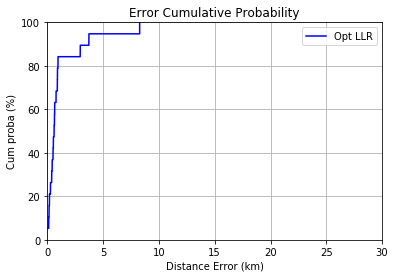

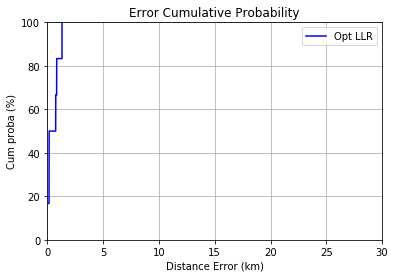

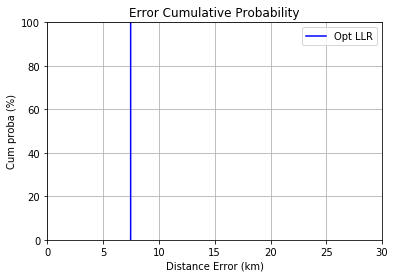

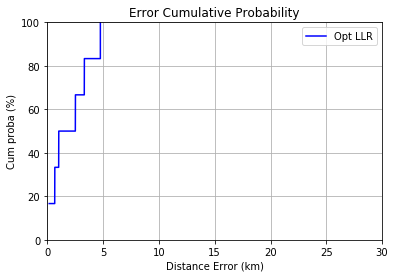

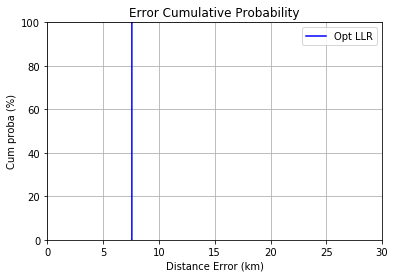

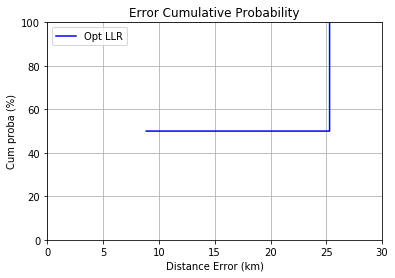

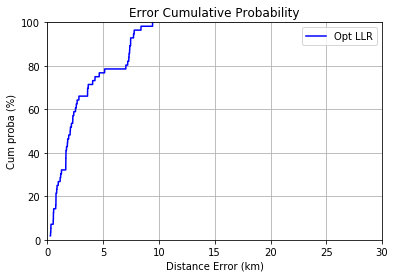

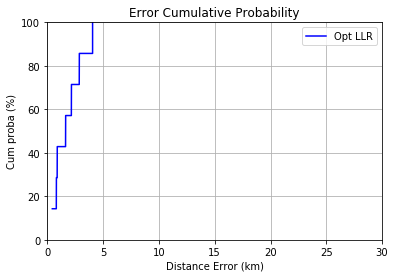

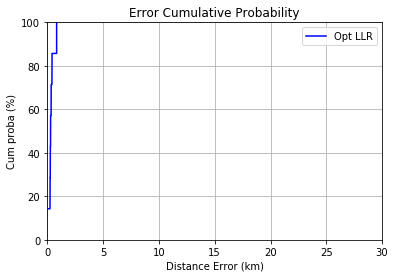

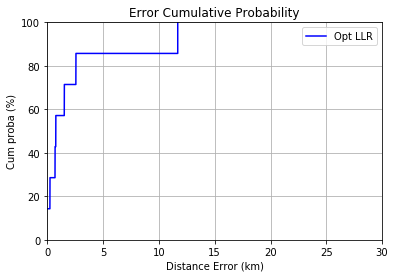

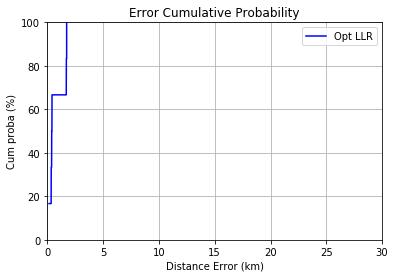

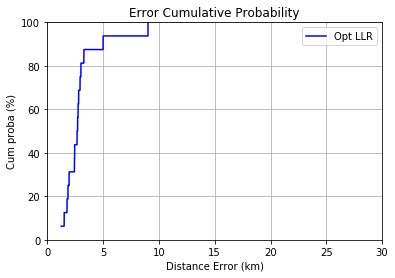

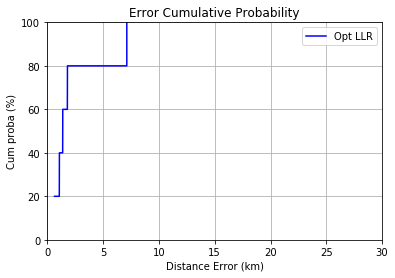

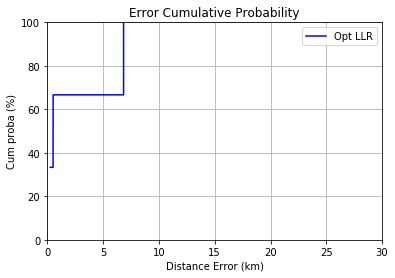

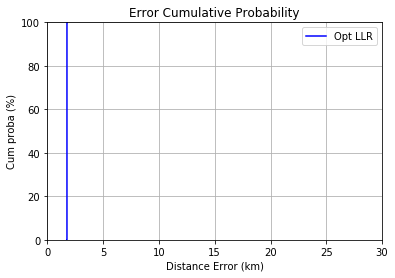

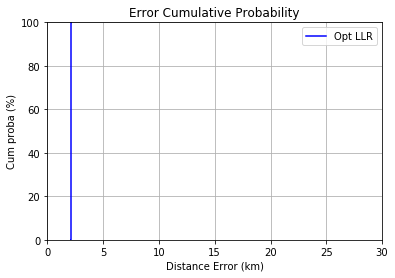

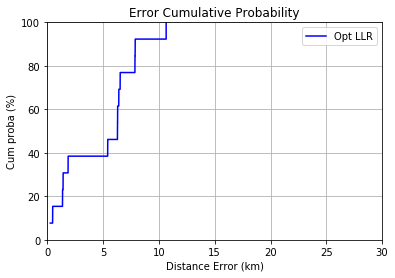

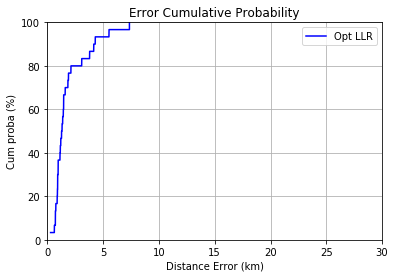

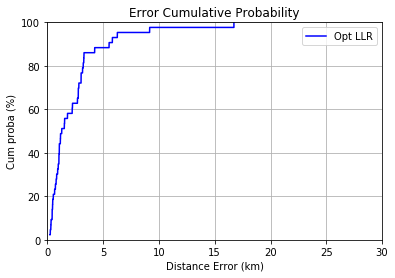

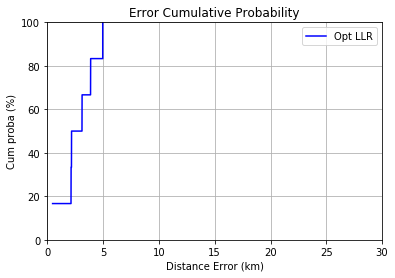

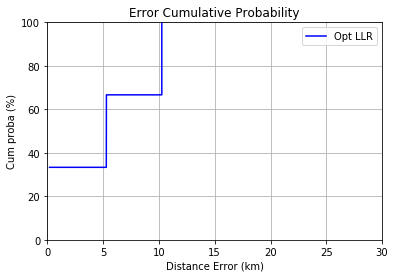

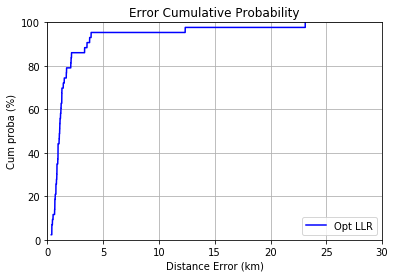

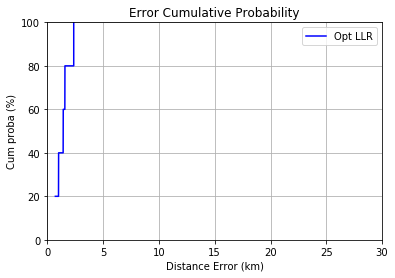

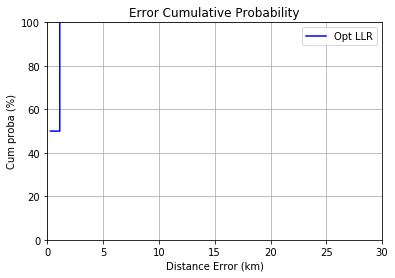

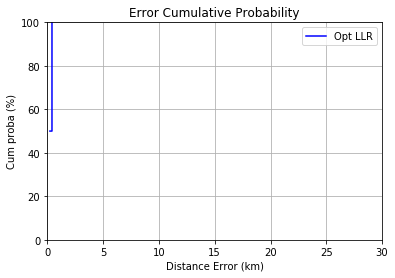

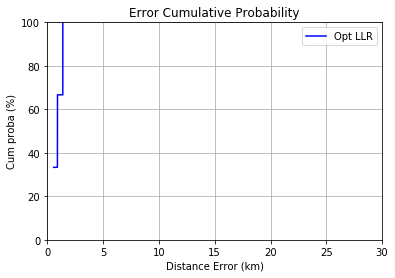

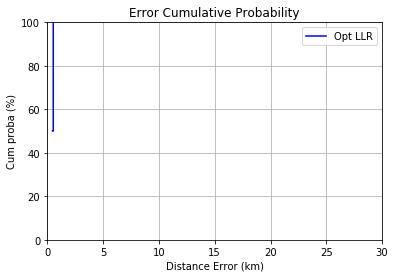

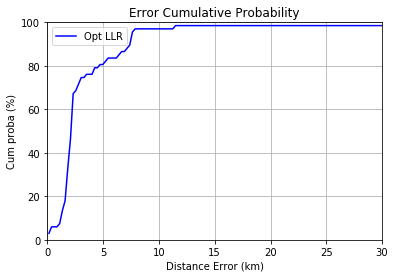

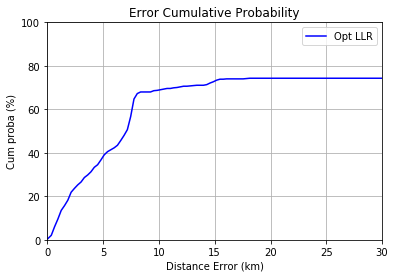

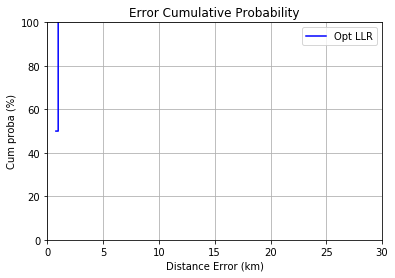

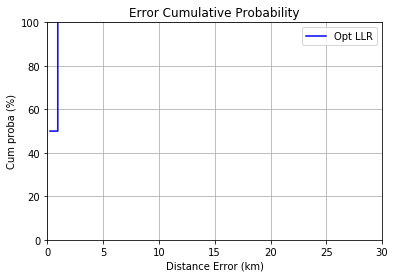

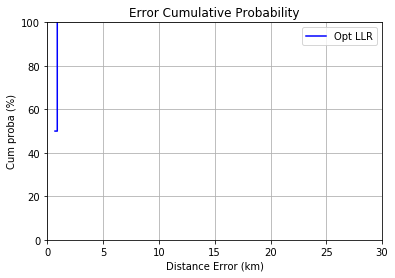

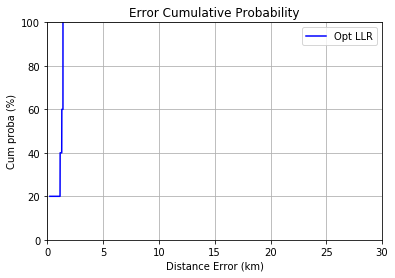

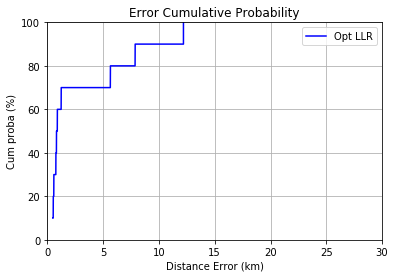

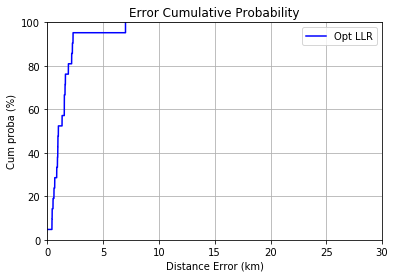

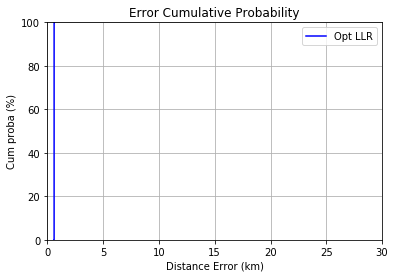

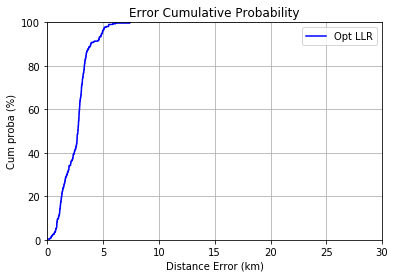

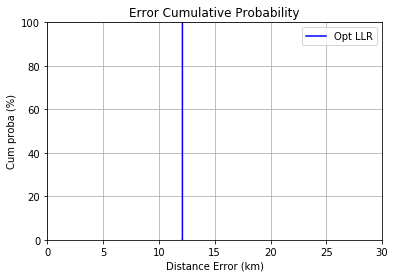

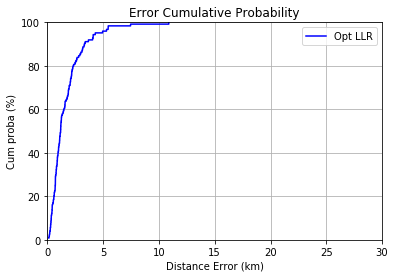

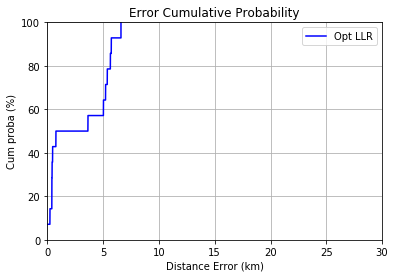

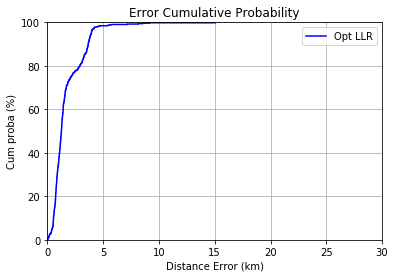

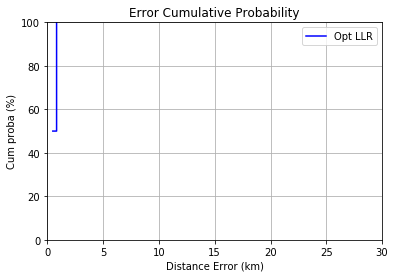

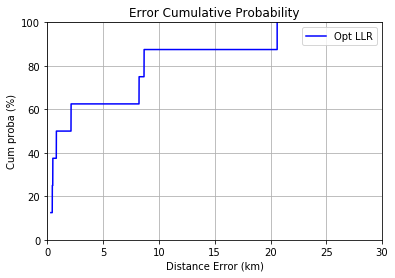

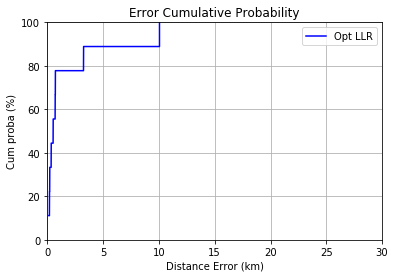

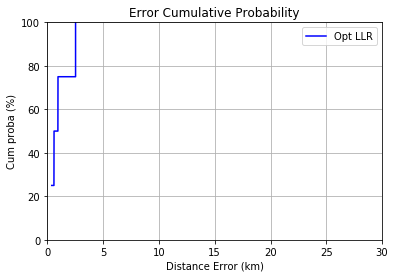

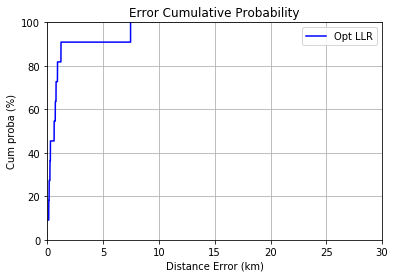

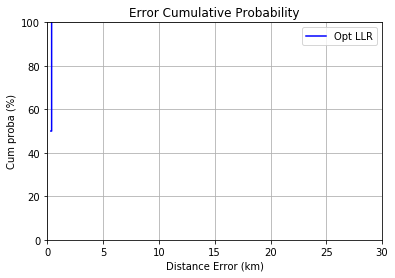

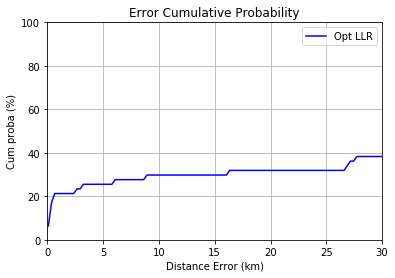

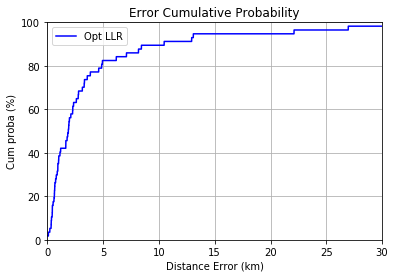

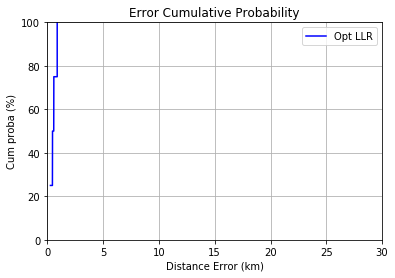

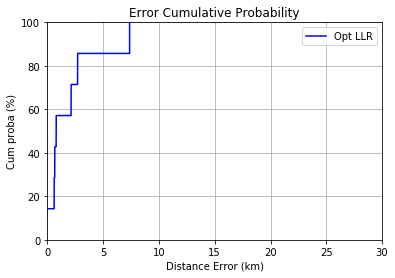

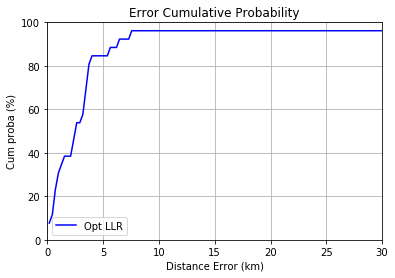

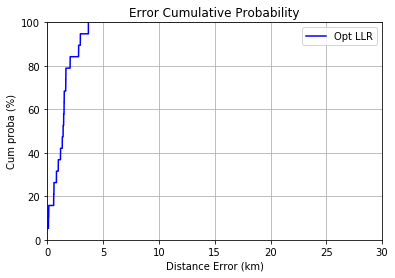

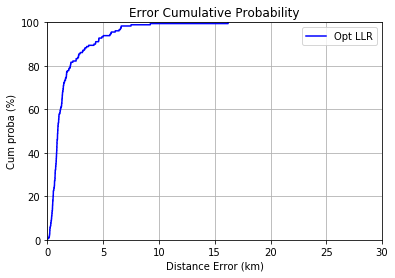

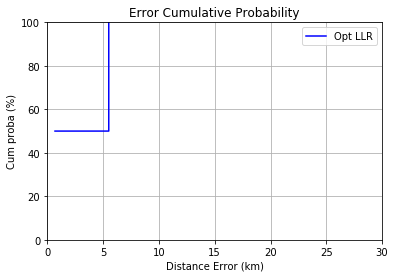

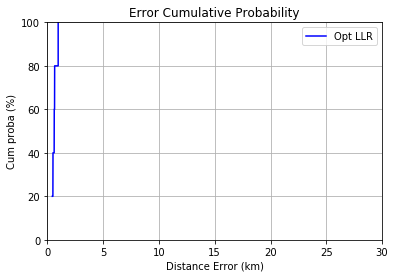

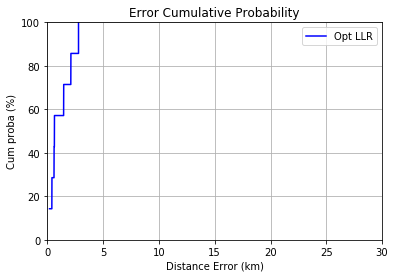

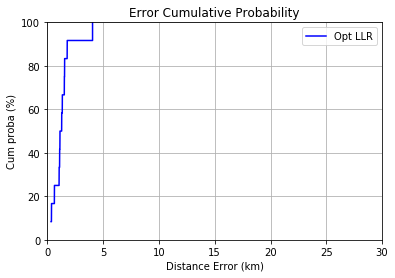

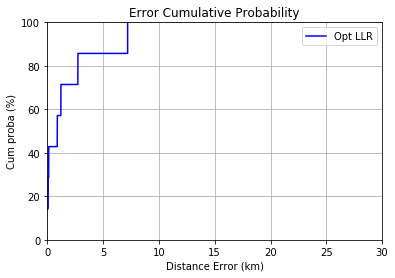

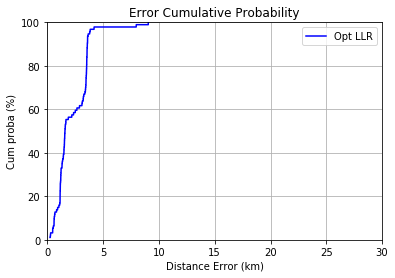

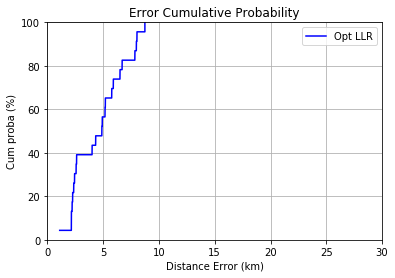

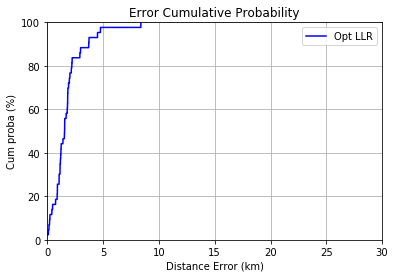

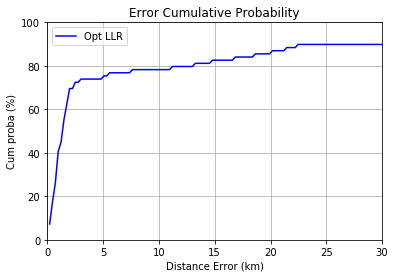

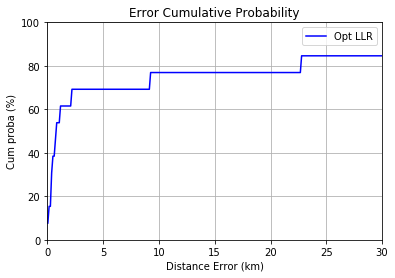

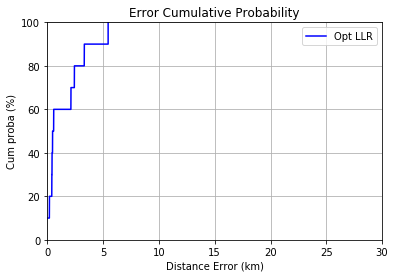

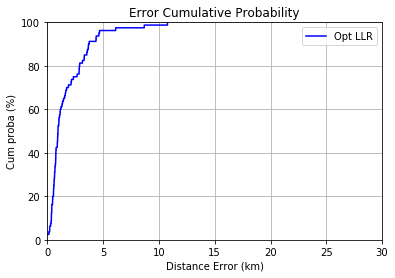

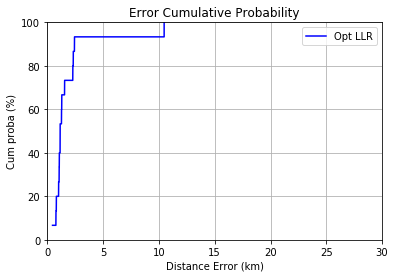

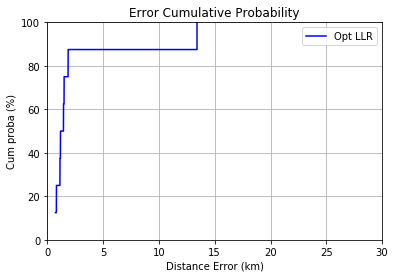

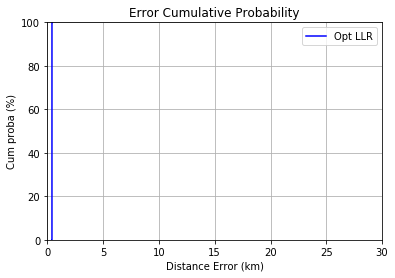

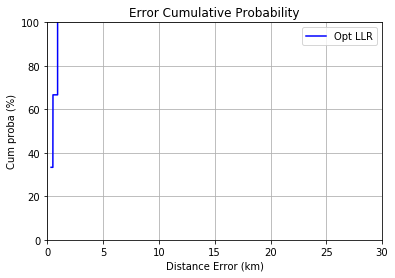

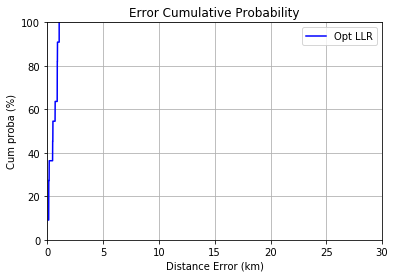

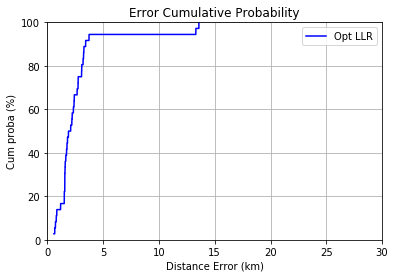

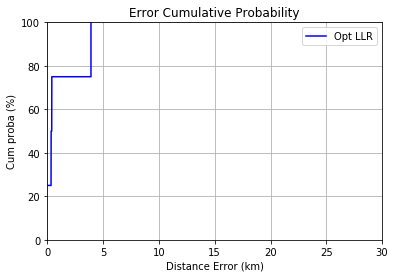

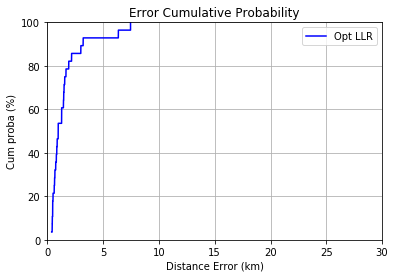

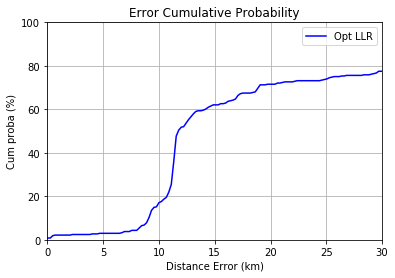

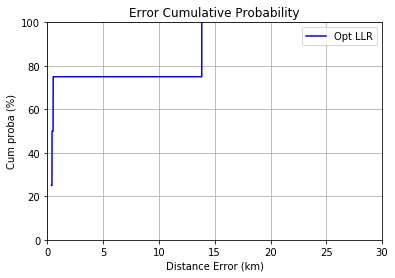

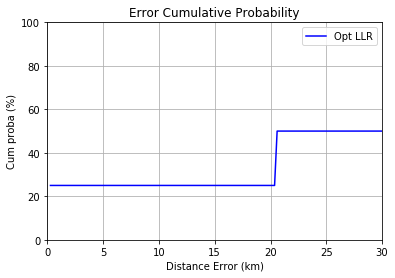

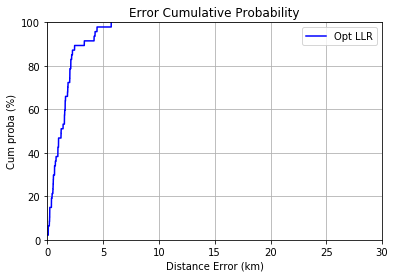

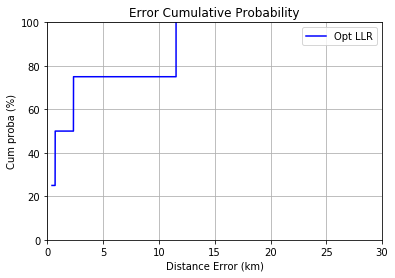

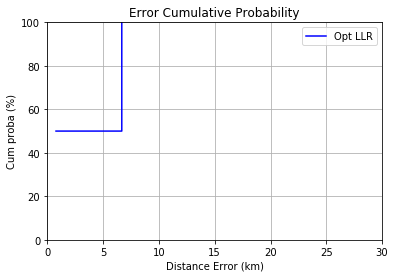

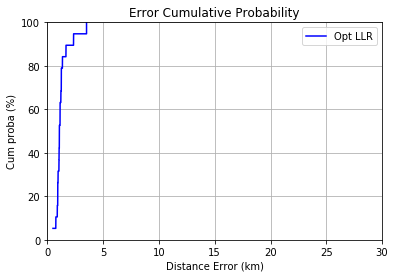

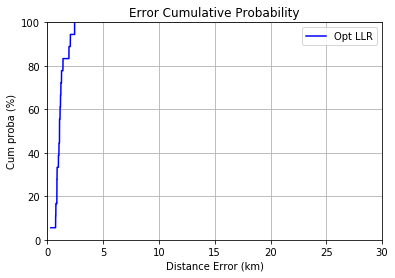

In [52]:
reg = linear_model.LinearRegression()
scores = get_error_per_obj(reg,liste_X_test_preprocessed,liste_X_train_preprocessed,liste_y_long_train_preprocessed,\
        liste_y_lat_train_preprocessed,liste_y_long_test_preprocessed, liste_y_lat_test_preprocessed)

In [53]:
np.argsort(scores)

array([ 30,  77,  55,  39,  99,  57,  66,  80,  86, 100,  72,  61,  32,
        62, 101,  76,  31,  60,  54,  12,  56,   5, 111, 112,   3,  63,
        23,  88,  75,  28,  41,  98,  74,  53,  17,  45,  13, 103,  83,
       104,  65,  52,  18,  87,  84,  15, 108,  46,   8,  92,  27,  97,
        48,  69,  26,  40,  89,  29,  81,  95,  38,  25,  43,  96,  71,
        42, 102,  49,   7,   6,  34,  67,  16,  24,  90,   2,  22,  50,
        82,  44,  10,  85,   1,  79,   9,  58,  11,  70, 110, 106, 109,
        64,  21,  91,  37,  47,  19,  33,  35,   4,  51,  73,  20,  14,
        68,  93,  94,  36, 105, 107,  78,  59,   0])

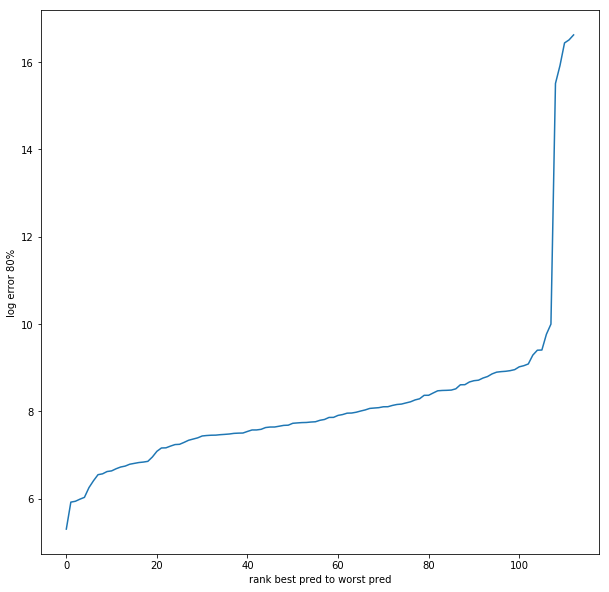

In [73]:
fig,ax = plt.subplots(figsize=(10,10))
ax = plt.plot(range(0,scores.shape[0]),np.log(np.sort(scores).tolist()))
plt.xlabel("rank best pred to worst pred")
plt.ylabel("log error 80%")

Plot du log de l'erreur à 80% pour chaque objet, l'échelle est logarithmique on constate donc que l'erreur à 80% en fonction des objets est très disparatre. Essayons de voir ce qui explique cela :

Evaluons le RSS moyen pour chaque objet en fonction de la performance de notre algorithme

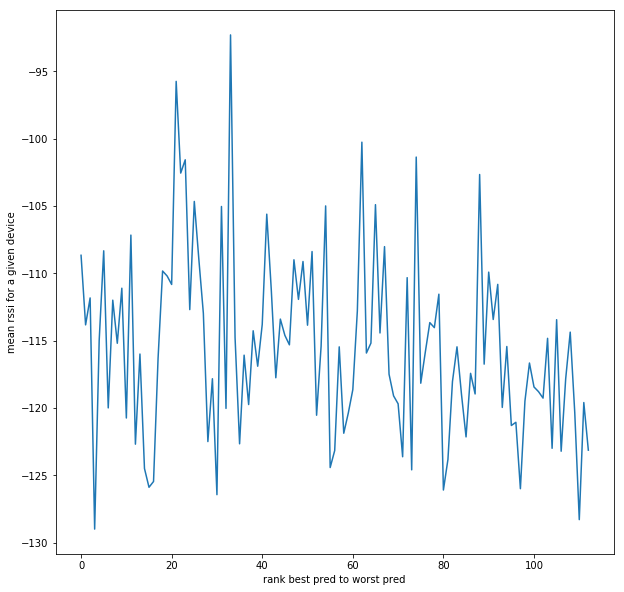

In [44]:
rss_mean =  np.zeros(scores.shape[0])
for i,device in enumerate(np.argsort(scores)) :
    rss_mean[i] = np.mean(liste_X_test_preprocessed[device][:,-1])
    
fig,ax = plt.subplots(figsize=(10,10))
ax = plt.plot(range(0,scores.shape[0]),rss_mean.tolist())
plt.xlabel("rank best pred to worst pred")
plt.ylabel("mean rssi for a given device")

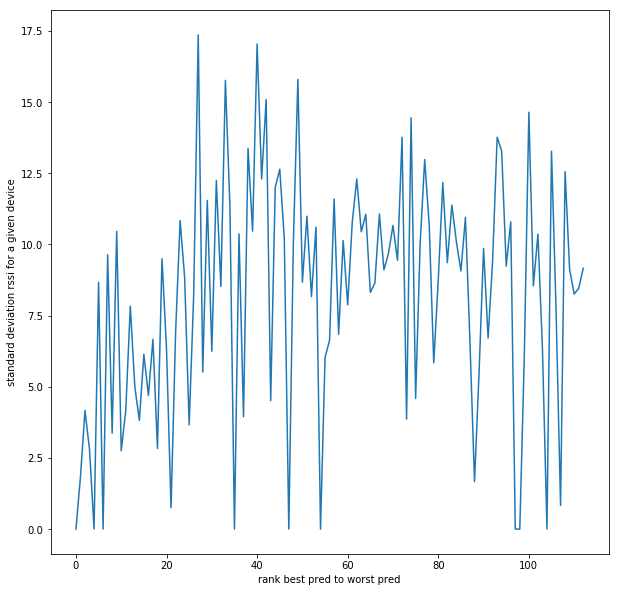

In [45]:
rss_mean =  np.zeros(scores.shape[0])
for i,device in enumerate(np.argsort(scores)) :
    rss_mean[i] = np.std(liste_X_test_preprocessed[device][:,-1])
    
fig,ax = plt.subplots(figsize=(10,10))
ax = plt.plot(range(0,scores.shape[0]),rss_mean.tolist())
plt.xlabel("rank best pred to worst pred")
plt.ylabel("standard deviation rssi for a given device")

Pas de relation évidente entre le score et le RSSI (moyen & std) de la première station -> les objets les plus mal classés ne sont forcément les plus éloignés vis à vis des autres des stations.

Evaluons l'influence du nombre de messages par objet sur la performance

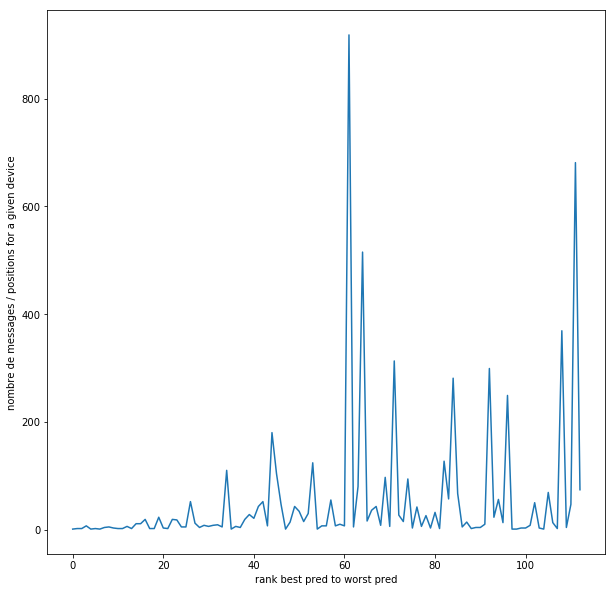

In [46]:
nb_msg =  np.zeros(scores.shape[0])
for i,device in enumerate(np.argsort(scores)) :
    nb_msg[i] = liste_X_test_preprocessed[device].shape[0]
    
fig,ax = plt.subplots(figsize=(10,10))
ax = plt.plot(range(0,scores.shape[0]),nb_msg.tolist())
plt.xlabel("rank best pred to worst pred")
plt.ylabel("nombre de messages / positions for a given device")

On remarque que plus un objet envoie de messages plus il semble y avoir d'erreur sur sa position. Pourquoi ?

In [54]:
#worst device 
liste_device[0]

473288.0

Interessons nous à l'objet présentant le plus d'erreur à 80% (objet d'id 473288). On constate (ci-dessous) que pour une même position en sortie, la station ayant le rssi le plus élevé n'est pas toujours la même.
Cela limite la performance du modèle linéaire et explique les erreurs associées à certains objets.

En outre plus on a de messages associés à un objet, plus on a de risques d'observer ce "phénomène", d'ou le graphique précédent.

In [87]:
#station (lat/long/rssi) au rssi le plus grand pour chaque message
array_station = liste_X_test_preprocessed[0][:,-3:]
array_pos = np.array(list(zip(liste_y_lat_test_preprocessed[0].tolist(),liste_y_long_test_preprocessed[0].tolist())))
pd.DataFrame(np.hstack((array_station,array_pos)),columns=['latitude_bs','longitude_bs','rssi',\
                                                          'latitude_objet','longitude_objet'])

,latitude_bs,longitude_bs,rssi,latitude_objet,longitude_objet
0,39.781464,-105.040763,-104.500000,39.775428,-105.039537
1,39.781464,-105.040763,-101.000000,39.774984,-105.039440
2,39.781464,-105.040763,-121.000000,39.774763,-105.039389
3,64.300000,-68.500000,-124.000000,39.774652,-105.039364
4,39.797706,-105.060234,-125.000000,39.774596,-105.039353
5,39.744848,-105.010048,-118.000000,39.774549,-105.039340
6,39.757034,-104.976127,-109.000000,39.774544,-105.039341
7,64.300000,-68.500000,-106.000000,39.774543,-105.039340
8,64.300000,-68.500000,-103.333333,39.774542,-105.039340
9,64.300000,-68.500000,-112.000000,39.774542,-105.039339


Nous avons pensé à ce niveau à complexifier le modèle en utilisant de l'ensemble learning et des algorithmes découpant l'espace (boosting de trees ou random forrest) tout en ajoutant d'avantage d'informations au niveau des bases. 

Considèrons les stations ayant les 2 meilleurs RSSI, par exemple, si 2 messages ont eu leurs 2 meilleurs RSSI sur les mêmes stations mais pas dans le même ordre, ces 2 messages auront tendance à être situé dans le même espace. On devrait donc réduire l'erreur pour les messages associées à une même position de l'objet mais n'étant pas associé à la même première station.

In [77]:
#2 stations considérées
preprocessed_train_2 = prep(df_mess_train,listOfBs)

In [78]:
#gradient boosting tuning
parameters = {'n_estimators':[100,250],'max_depth':[2,10,50]}

grid_cv = GridSearchCV(GradientBoostingRegressor(),param_grid=parameters)
grid_cv.fit(preprocessed_train_2,ground_truth_lat)
pd.DataFrame(grid_cv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.327487,0.010845,0.977757,0.994765,2,100,"{'max_depth': 2, 'n_estimators': 100}",5,0.952987,0.995740,0.994306,0.993572,0.985981,0.994984,0.098732,0.006824,0.017843,0.000898
1,5.664309,0.010274,0.977945,0.996047,2,250,"{'max_depth': 2, 'n_estimators': 250}",4,0.951354,0.996792,0.994824,0.995256,0.987663,0.996093,0.235704,0.001747,0.019031,0.000628
2,9.608452,0.017773,0.981179,0.999281,10,100,"{'max_depth': 10, 'n_estimators': 100}",1,0.964201,0.999432,0.992668,0.999227,0.986671,0.999184,0.286189,0.003342,0.012254,0.000108
3,24.842350,0.035651,0.978220,0.999642,10,250,"{'max_depth': 10, 'n_estimators': 250}",3,0.956961,0.999697,0.992325,0.999634,0.985376,0.999595,0.916941,0.000973,0.015299,0.000042
4,18.100520,0.039881,0.978650,0.999807,50,100,"{'max_depth': 50, 'n_estimators': 100}",2,0.959133,0.999819,0.991649,0.999824,0.985172,0.999779,0.573462,0.011468,0.014053,0.000020
5,62.133389,0.100334,0.976838,0.999807,50,250,"{'max_depth': 50, 'n_estimators': 250}",6,0.952662,0.999819,0.992545,0.999824,0.985311,0.999779,4.412453,0.015334,0.017350,0.000020


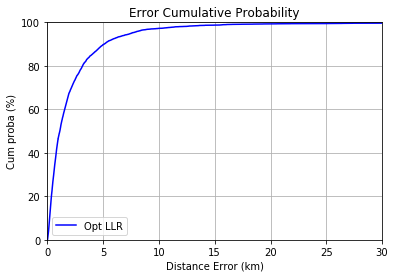

In [82]:
rand_grad = GradientBoostingRegressor(n_estimators = 100,max_depth=10)
y_pred_lng = cross_val_predict(rand_grad, preprocessed_train_2, ground_truth_lng, cv=10)
y_pred_lat = cross_val_predict(rand_grad, preprocessed_train_2, ground_truth_lat, cv=10)
err = err_80(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

In [127]:
print(err)

3148.36972788


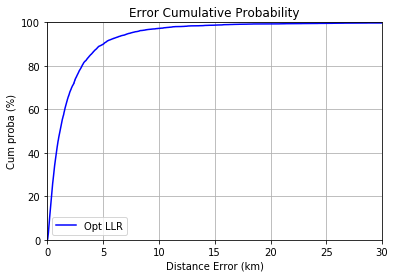

In [147]:
#3 stations (sans repasser par 1 grid search)
preprocessed_train_3 = preprocessing_gen(df_mess_train,listOfBs,3)
rand_grad = GradientBoostingRegressor(n_estimators = 100,max_depth=10)
y_pred_lng = cross_val_predict(rand_grad, preprocessed_train_3, ground_truth_lng, cv=10)
y_pred_lat = cross_val_predict(rand_grad, preprocessed_train_3, ground_truth_lat, cv=10)
err = err_80(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

In [148]:
print(err)

3112.41591595


On observe une amélioration de l'erreur à 80%, néanmoins le temps de calcul nécessaire pour fitter le modèle aux données ne le rend  pas pertinent pour effectuer le 1-device out.
Au vue de la faible amélioration (~150m), nous avons choisi de conserver le modèle linéaire.

### -- Test prediction -- 

In [38]:
# Construct test prediction

In [149]:
df_mess_test.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [150]:
preprocessed_test = preprocessing_gen(df_mess_test,listOfBs,1)

In [151]:
y_pred_lat, y_pred_lng = regressor_and_predict(preprocessed_train,preprocessed_train,ground_truth_lat,ground_truth_lng,preprocessed_test)

In [152]:
y_pred_lat.shape

(5294,)

In [153]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])

In [154]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [102]:
preprocessed_test[1000:1050,-3:]

array([[  39.71631692, -105.13254993, -134.        ],
       [  39.75501938, -105.04331476, -112.        ],
       [  39.73204486, -104.97365083, -114.33333333],
       [  39.95584247, -105.15439221, -105.66666667],
       [  39.69297592, -105.04437127, -118.        ],
       [  40.00346613, -105.34497884, -131.        ],
       [  39.65468188, -105.04368528, -117.        ],
       [  39.69297592, -105.04437127, -126.        ],
       [  40.00346613, -105.34497884, -132.66666667],
       [  39.61274458, -105.00882658, -130.        ],
       [  39.69297592, -105.04437127, -124.5       ],
       [  39.65468188, -105.04368528, -114.        ],
       [  39.65468188, -105.04368528, -122.        ],
       [  39.81005466, -105.01041344, -101.33333333],
       [  39.72315055, -104.95621566, -121.        ],
       [  39.75703352, -104.97612676, -119.66666667],
       [  39.72315055, -104.95621566, -124.        ],
       [  39.73204486, -104.97365083, -133.        ],
       [  39.65468188, -105.

In [197]:
test_res.head(20)

,lat,lng
0,3.973734e+01,-1.050872e+02
1,3.977237e+01,-1.050845e+02
2,3.967658e+01,-1.050038e+02
3,3.978172e+01,-1.050653e+02
4,3.967599e+01,-1.050034e+02
5,3.977237e+01,-1.050845e+02
6,3.978526e+01,-1.050679e+02
7,3.974275e+01,-1.049846e+02
8,3.970882e+01,-1.050124e+02
9,3.979761e+01,-1.050649e+02
